# Summary
Exploring the jaccard scores generated between fragments+neutral losses and MDs.

Scores are organised in a (large) csv that looks like this:
```
    fragment0 →
MD0 Jaccard0,0
↓
```

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import time

data_path = "/mnt/scratch/louwe015/Mass_differences/data/"

## Determine AllPositive version; default is version 2

In [2]:
all_pos_version1 = False
if all_pos_version1:
    all_pos = "gnps_positive_ionmode_cleaned_by_matchms_and_lookups"
else:
    all_pos = "ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups"

print(all_pos)

ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups


In [3]:
if all_pos_version1:
    jacc_mat_file = "jaccard_matrix_allpos1_25-2-2021.csv"
else:
    jacc_mat_file = "jaccard_matrix_allpos2_25-2-2021.csv"
print(jacc_mat_file)

jaccard_matrix_allpos2_25-2-2021.csv


## Explore jaccard matrix

In [4]:
jacc_mat_path = os.path.join(data_path, "jaccard_matrices", jacc_mat_file)
print(jacc_mat_path, os.path.isfile(jacc_mat_path))

/mnt/scratch/louwe015/Mass_differences/data/jaccard_matrices/jaccard_matrix_allpos2_25-2-2021.csv True


In [5]:
# record rows, cols and dict of 5 highest scores {md:vals}
cols = []
rows = []
md_dict5 = {}
start = time.time()
with open(jacc_mat_path) as inf:
    header = inf.readline()
    cols = header.strip(", ").split(",")
    print("Number of fragments and neutral losses:", len(cols))
    for line in inf:
        line = line.strip().split(",")
        md = line.pop(0)
        top5 = sorted(map(float, line), reverse=True)[:5]
        md_dict5[md] = top5
        rows.append(md)
        rowlen = len(rows)
        if rowlen % 2000 == 0:
            print("At MD", rowlen)
end = time.time()
print("Took {:.3f} hours".format((end-start)/3600))

Number of fragments and neutral losses: 115913
At MD 2000
At MD 4000
At MD 6000
At MD 8000
At MD 10000
At MD 12000
At MD 14000
At MD 16000
At MD 18000
At MD 20000
At MD 22000
At MD 24000
At MD 26000
At MD 28000
At MD 30000
At MD 32000
At MD 34000
At MD 36000
At MD 38000
At MD 40000
At MD 42000
At MD 44000
At MD 46000
At MD 48000
At MD 50000
At MD 52000
At MD 54000
At MD 56000
At MD 58000
At MD 60000
Took 0.346 hours


In [6]:
# I should save this top5 dict to compare with occurrences for example.
top5_file = os.path.join(data_path, "jaccard_matrices", jacc_mat_file.partition(".csv")[0]+"_top5_dict.pickle")
with open(top5_file, 'wb') as outf:
    pickle.dump(md_dict5, outf)

In [19]:
[md_dict5[md] for md in rows[:5]]

[[0.06630971993410215,
  0.06272530641672674,
  0.05877309221295502,
  0.05828996282527881,
  0.057673745173745176],
 [0.21908169350029816,
  0.20482897384305834,
  0.18041464490516101,
  0.17011853588641396,
  0.1649621599509102],
 [0.18679829655439412,
  0.18562513685132473,
  0.17540398346486283,
  0.16659663865546218,
  0.16403107609234668],
 [0.04163251925913784,
  0.040095881455654826,
  0.03920525102004612,
  0.037328339575530584,
  0.03689902089726728],
 [0.0503125,
  0.047068021892103205,
  0.044156467482601394,
  0.04302624806999485,
  0.04291154071470416]]

In [28]:
max_vals = []
for md in rows:
    vals = md_dict5[md]
    max_vals.append(max(vals))

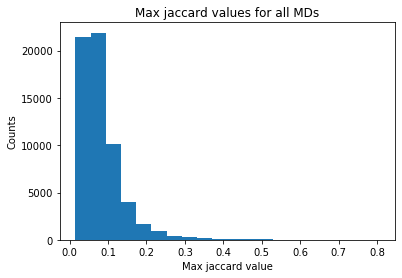

In [29]:
plt.hist(max_vals, bins=20)
plt.title("Max jaccard values for all MDs")
plt.xlabel("Max jaccard value")
plt.ylabel("Counts")
plt.show()

## Read whole matrix with pandas
Remove low values? Save as sparse matrix? Save as compressed numpy array (savez)?

- remove values lower than... 0.01 or so
- remove column and index and save to separate array
- convert matrix to COO sparse matrix
- convert to csr sparse matrix
- save as compressed numpy array np.savez
- incorporate in jaccard matrix calc script

In [7]:
start = time.time()
jacc_matrix = pd.read_csv(jacc_mat_path, header=0, index_col=0, dtype=np.float64)
end = time.time()
print("Reading jacc matrix with pandas took: {} hours".format((end-start)/3600))

Reading jacc matrix with pandas took: 3.1342127988735835 hours


In [13]:
jacc_matrix.iloc[:1]

,peak@4.59,loss@5.00,loss@5.01,loss@5.02,loss@5.03,loss@5.04,loss@5.05,loss@5.06,loss@5.07,loss@5.08,...,peak@999.91,peak@999.92,peak@999.93,peak@999.94,peak@999.95,peak@999.96,peak@999.97,peak@999.98,peak@999.99,peak@1000.00
51.0,0.0,0.001079,0.0,0.000802,0.000537,0.0008,0.002146,0.002124,0.000268,0.000268,...,0.00027,0.000271,0.0,0.0,0.0,0.0,0.0,0.000271,0.0,0.0


In [19]:
zeros = (jacc_matrix == 0).sum(axis=1).sum(axis=0)
num_values = jacc_matrix.shape[0] * jacc_matrix.shape[1]
print("{}% of matrix are 0s".format(zeros/num_values*100))

94.59342438639139% of matrix are 0s


### Do some testing on first 100 lines of file
I did: head -100 jaccard_matrix_allpos2_25-2-2021.csv > jaccard_matrix_allpos2_25-2-2021_first_100.csv

In [52]:
jacc_first_name = "jaccard_matrix_allpos2_25-2-2021_first_1000.csv"
jacc_first_file = os.path.join(data_path, "jaccard_matrices", jacc_first_name)
print(jacc_first_file, os.path.exists(jacc_first_file))

/mnt/scratch/louwe015/Mass_differences/data/jaccard_matrices/jaccard_matrix_allpos2_25-2-2021_first_1000.csv True


In [53]:
start = time.time()
jacc_first = pd.read_csv(jacc_first_file, header=0, index_col=0, dtype=np.float64)
end = time.time()
print("Reading jacc matrix with pandas took: {} hours".format((end-start)/3600))

Reading jacc matrix with pandas took: 0.08724653846687741 hours


In [54]:
jacc_first

,peak@4.59,loss@5.00,loss@5.01,loss@5.02,loss@5.03,loss@5.04,loss@5.05,loss@5.06,loss@5.07,loss@5.08,...,peak@999.91,peak@999.92,peak@999.93,peak@999.94,peak@999.95,peak@999.96,peak@999.97,peak@999.98,peak@999.99,peak@1000.00
51.00,0.0,0.001079,0.000000,0.000802,0.000537,0.000800,0.002146,0.002124,0.000268,0.000268,...,0.000270,0.000271,0.000000,0.000000,0.0,0.0,0.000000,0.000271,0.0,0.0
51.01,0.0,0.000000,0.000386,0.001541,0.000965,0.001731,0.001157,0.000765,0.000386,0.000193,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
51.02,0.0,0.000000,0.000147,0.000440,0.000735,0.000586,0.000441,0.000438,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000148,0.0,0.0,0.000148,0.000000,0.0,0.0
51.03,0.0,0.000000,0.000000,0.000765,0.000769,0.000762,0.000767,0.000756,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
51.04,0.0,0.000000,0.000000,0.000399,0.000000,0.000795,0.000400,0.000788,0.000401,0.000799,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39.94,0.0,0.000000,0.000000,0.001046,0.003188,0.000000,0.000000,0.001012,0.000000,0.001052,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.001101,0.000000,0.0,0.0
39.95,0.0,0.000000,0.000000,0.000000,0.001643,0.000000,0.000000,0.002379,0.000820,0.001633,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
39.96,0.0,0.001291,0.000321,0.000638,0.000000,0.000318,0.000000,0.005078,0.000962,0.000639,...,0.000323,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
39.97,0.0,0.000000,0.000634,0.000000,0.000633,0.000000,0.001893,0.000000,0.000633,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [55]:
import scipy.sparse as sp

sparse_first = sp.csr_matrix(jacc_first.values)
sparse_first

<999x115913 sparse matrix of type '<class 'numpy.float64'>'
	with 16409285 stored elements in Compressed Sparse Row format>

In [56]:
x = 10

start = time.time()
a = sp.csr_matrix(jacc_first.values)
for _ in range(x):
    a = sp.vstack([a, sp.csr_matrix(jacc_first.values)])
end = time.time()
print((end - start)/x)

8.025289607048034


In [57]:
x = 10

start = time.time()
b = sp.coo_matrix(jacc_first.values)
for _ in range(x):
    b = sp.vstack([b, sp.coo_matrix(jacc_first.values)])
end = time.time()
print((end - start)/x)

9.47354474067688


In [62]:
cols = jacc_first.columns
rows = jacc_first.index
cols,rows  # use to_list() methods

(Index(['peak@4.59', 'loss@5.00', 'loss@5.01', 'loss@5.02', 'loss@5.03',
        'loss@5.04', 'loss@5.05', 'loss@5.06', 'loss@5.07', 'loss@5.08',
        ...
        'peak@999.91', 'peak@999.92', 'peak@999.93', 'peak@999.94',
        'peak@999.95', 'peak@999.96', 'peak@999.97', 'peak@999.98',
        'peak@999.99', 'peak@1000.00'],
       dtype='object', length=115913),
 Float64Index([ 51.0, 51.01, 51.02, 51.03, 51.04, 51.05, 51.06, 51.07, 51.08,
               51.09,
               ...
               39.89,  39.9, 39.91, 39.92, 39.93, 39.94, 39.95, 39.96, 39.97,
               39.98],
              dtype='float64', length=999))